In [76]:
!pip install pytesseract pdf2image transformers sqlalchemy easyocr pandas matplotlib Pillow
!apt-get install poppler-utils tesseract-ocr -y
!apt-get install poppler-utils -qq
!apt-get install -qq poppler-utils tesseract-ocr
!pip install -q openai

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.11).
0 upgraded, 0 newly installed, 0 to remove and 51 not upgraded.


In [77]:
!apt-get install -qq poppler-utils tesseract-ocr
import os, re, io, json, sqlite3, pytesseract, torch
import pandas as pd
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from PIL import Image
from sqlalchemy import create_engine
from google.colab import drive

from openai import OpenAI

# Mount Google Drive
drive.mount('/content/drive')

# Config
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"
os.makedirs("invoices", exist_ok=True)
engine = create_engine("sqlite:////content/drive/MyDrive/invoices.db")

# Optional GPT API setup (only if you have a key stored in Drive or manually added)
api_key_path = "/content/drive/MyDrive/openai_api_key.txt"
if os.path.exists(api_key_path):
    with open(api_key_path) as f:
        os.environ["OPENAI_API_KEY"] = f.read().strip()
    client = OpenAI()
    print("✅ GPT API key loaded successfully.")
else:
    client = None
    print("⚠️ GPT extraction disabled (no API key found).")

print("✅ Environment ready.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⚠️ GPT extraction disabled (no API key found).
✅ Environment ready.


In [79]:
def extract_text_from_invoice(file_path):
    text = ""
    if file_path.lower().endswith(".pdf"):
        try:
            pages = convert_from_path(file_path)
            text = "\n".join(pytesseract.image_to_string(p) for p in pages)
        except Exception as e:
            print(f"⚠️ Error reading PDF {file_path}: {e}")
            return ""
    elif file_path.lower().endswith((".png", ".jpg", ".jpeg")):
        img = Image.open(file_path)
        text = pytesseract.image_to_string(img)
    else:
        raise ValueError("Unsupported file format.")
    return text


def extract_invoice_fields(text):
    # --- Step 1: Regex-based quick extraction ---
    fields = {}
    fields["invoice_number"] = re.findall(r"(?:Invoice\s*#?:?\s*)([A-Z0-9\-]+)", text, re.I)
    fields["invoice_date"] = re.findall(r"(\b\d{1,2}[\/\-\s]\d{1,2}[\/\-\s]\d{2,4}\b)", text)
    fields["vendor_name"]  = re.findall(r"(?:From|Vendor|Billed by)[:\s\-]+([A-Za-z0-9\s&]+)", text)
    fields["total_amount"] = re.findall(r"(?:Total|Amount Due|Balance)\s*\$?\s*([\d,]+\.\d{2})", text, re.I)

    # --- Step 2: Line item parsing ---
    lines = re.findall(r"([A-Za-z\s]+)\s+(\d+)\s+\$?([\d,]+\.\d{2})", text)
    items = []
    for desc, qty, price in lines:
        try:
            qty = int(qty)
            price = float(price.replace(",", ""))
            total = qty * price
            items.append({
                "description": desc.strip(),
                "quantity": qty,
                "unit_price": price,
                "line_total": total
            })
        except ValueError:
            continue

    data = {
        "invoice_number": fields["invoice_number"][0].strip() if fields["invoice_number"] else None,
        "invoice_date": fields["invoice_date"][0].strip() if fields["invoice_date"] else None,
        "vendor_name": re.sub(r"[^A-Za-z0-9\s&]", "", fields["vendor_name"][0]).strip() if fields["vendor_name"] else "Unknown Vendor",
        "total_amount": fields["total_amount"][0].replace(",", "").strip() if fields["total_amount"] else None,
        "line_items": items
    }

    # --- Step 3: GPT-enhanced extraction (if available) ---
    if 'client' in globals() and client is not None:
        try:
            prompt = f"""
            Extract these fields from the text below in strict JSON:
            invoice_number, invoice_date, vendor_name, total_amount, and line_items (list of description, quantity, unit_price, line_total).

            Text:
            {text[:4000]}
            """
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0,
            )
            content = response.choices[0].message.content
            json_match = re.search(r"\{.*\}", content, re.DOTALL)
            if json_match:
                gpt_data = json.loads(json_match.group(0))
                # Fill missing regex fields using GPT predictions
                for k in ["invoice_number", "invoice_date", "vendor_name", "total_amount"]:
                    if not data.get(k) and gpt_data.get(k):
                        data[k] = gpt_data[k]
                if gpt_data.get("line_items"):
                    data["line_items"] = gpt_data["line_items"]
        except Exception as e:
            print(f"⚠️ GPT extraction failed: {e}")

    return data


In [81]:
import os, re, json
import pandas as pd
from sqlalchemy import create_engine
from pdf2image import convert_from_path
from PIL import Image
import pytesseract

# --- config ---
folder = "/content/drive/MyDrive/invoice.xlsx"  # can be folder OR single file
engine = create_engine("sqlite:///invoices.db")

def extract_text_from_invoice(file_path):
    if file_path.lower().endswith(".pdf"):
        try:
            pages = convert_from_path(file_path)
            return "\n".join(pytesseract.image_to_string(p) for p in pages)
        except Exception as e:
            print(f"⚠️ PDF extraction error: {e}")
            return ""
    elif file_path.lower().endswith((".png", ".jpg", ".jpeg")):
        try:
            img = Image.open(file_path)
            return pytesseract.image_to_string(img)
        except Exception as e:
            print(f"⚠️ Image OCR error: {e}")
            return ""
    elif file_path.lower().endswith((".xlsx", ".csv")):
        return None
    else:
        raise ValueError(f"Unsupported file format: {file_path}")

def extract_invoice_fields(text):
    if not text:
        return {}
    fields = {}
    fields["invoice_number"] = re.findall(r"(?:Invoice\s*#?:?\s*)([A-Z0-9\-]+)", text, re.I)
    fields["invoice_date"] = re.findall(r"(\b\d{1,2}[\/\-\s]\d{1,2}[\/\-\s]\d{2,4}\b)", text)
    fields["vendor_name"]  = re.findall(r"(?:From|Vendor|Billed by)[:\s\-]+([A-Za-z0-9\s&]+)", text)
    fields["total_amount"] = re.findall(r"(?:Total|Amount Due|Balance)\s*\$?\s*([\d,]+\.\d{2})", text, re.I)

    # Detect line items
    lines = re.findall(r"([A-Za-z\s]+)\s+(\d+)\s+\$?([\d,]+\.\d{2})", text)
    items = []
    for d, q, p in lines:
        try:
            qty = int(q)
            price = float(p.replace(",", ""))
            total = qty * price
            items.append({
                "description": d.strip(),
                "quantity": qty,
                "unit_price": price,
                "line_total": total
            })
        except:
            continue

    data = {
        "invoice_number": fields["invoice_number"][0].strip() if fields["invoice_number"] else None,
        "invoice_date": fields["invoice_date"][0].strip() if fields["invoice_date"] else None,
        "vendor_name": fields["vendor_name"][0].strip() if fields["vendor_name"] else "Unknown Vendor",
        "total_amount": fields["total_amount"][0].replace(",", "").strip() if fields["total_amount"] else None,
        "line_items": items
    }

    # --- Optional GPT Fallback ---
    if 'client' in globals() and client is not None:
        try:
            prompt = f"""
            Extract these fields in strict JSON:
            invoice_number, invoice_date, vendor_name, total_amount,
            and line_items (list of {{description, quantity, unit_price, line_total}}).
            Text: {text[:4000]}
            """
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.0
            )
            content = response.choices[0].message.content
            json_match = re.search(r"\{.*\}", content, re.DOTALL)
            if json_match:
                gpt_data = json.loads(json_match.group(0))
                for k, v in gpt_data.items():
                    if not data.get(k) and v:
                        data[k] = v
        except Exception as e:
            print(f"⚠️ GPT fallback failed: {e}")
    return data


records = []

# --- handle single file vs folder ---
if os.path.isfile(folder):
    print("📄 Detected single file:", folder)
    if folder.lower().endswith((".xlsx", ".csv")):
        df_input = pd.read_excel(folder) if folder.endswith(".xlsx") else pd.read_csv(folder)
        if 'Final_Output' in df_input.columns:
            print("✨ Parsing 'Final_Output' JSON column...")
            def parse_final_output(json_str):
                try:
                    data = json.loads(json_str)
                    return {
                        "invoice_number": data.get("INVOICE_NUMBER"),
                        "invoice_date": data.get("DATE") or data.get("DATE_ISSUED"),
                        "vendor_name": data.get("VENDOR_NAME") or "Unknown Vendor",
                        "total_amount": data.get("TOTAL_AMOUNT"),
                        "file_name": os.path.basename(folder)
                    }
                except:
                    return {}
            parsed = df_input['Final_Output'].apply(parse_final_output)
            df_output = pd.json_normalize(parsed)
            df_output["file_name"] = os.path.basename(folder)
            df_output.to_csv("structured_invoices.csv", index=False)
            df_output.to_sql("invoices", con=engine, if_exists="replace", index=False)
            print("✅ Parsed JSON invoices:", len(df_output))
        else:
            df_input.to_sql("invoices", con=engine, if_exists="replace", index=False)
            df_input.to_csv("structured_invoices.csv", index=False)
            print("✅ Loaded raw Excel/CSV:", len(df_input))
    else:
        text = extract_text_from_invoice(folder)
        data = extract_invoice_fields(text)
        data["file_name"] = os.path.basename(folder)
        data["ocr_text"] = text[:800]
        data["line_items"] = json.dumps(data["line_items"])
        records.append(data)
else:
    files = [os.path.join(folder, f) for f in os.listdir(folder)
             if f.lower().endswith((".pdf", ".jpg", ".jpeg", ".png", ".csv", ".xlsx"))]
    for f in files:
        print(f"Processing {os.path.basename(f)} ...")
        if f.lower().endswith((".xlsx", ".csv")):
            df_part = pd.read_excel(f) if f.endswith(".xlsx") else pd.read_csv(f)
            df_part["file_name"] = os.path.basename(f)
            records.extend(df_part.to_dict(orient="records"))
        else:
            text = extract_text_from_invoice(f)
            data = extract_invoice_fields(text)
            data["file_name"] = os.path.basename(f)
            data["ocr_text"] = text[:800]
            data["line_items"] = json.dumps(data["line_items"])
            records.append(data)

if records and not os.path.isfile(folder):
    df = pd.DataFrame(records)
    df.to_csv("structured_invoices.csv", index=False)
    df.to_sql("invoices", con=engine, if_exists="replace", index=False)
    print(f"✅ Processed {len(df)} files successfully from folder.")
    display(df.head())
elif os.path.isfile(folder):
    pass
else:
    print("⚠️ No valid invoices found.")


📄 Detected single file: /content/drive/MyDrive/invoice.xlsx
✨ Parsing 'Final_Output' JSON column...
✅ Parsed JSON invoices: 67


In [82]:
import pandas as pd
import sqlite3, json

# --- Step 0: Load from database ---
conn = sqlite3.connect("invoices.db")
try:
    data = pd.read_sql("SELECT * FROM invoices", conn)
    print("✅ Loaded data from SQLite:", len(data), "rows.")
except Exception as e:
    print(f"⚠️ Could not load data from database: {e}")
    data = pd.DataFrame()

# --- Step 1: Handle JSON column if present ---
if 'Final_Output' in data.columns:
    print("✨ Parsing JSON data from 'Final_Output' column...")

    def parse_final_output(json_string):
        if not isinstance(json_string, str) or not json_string.strip():
            return {}
        try:
            obj = json.loads(json_string)
            return {
                "invoice_number": obj.get("INVOICE_NUMBER") or obj.get("INVOICE_NO"),
                "invoice_date": obj.get("DATE") or obj.get("DATE_ISSUED"),
                "vendor_name": obj.get("VENDOR_NAME") or obj.get("BILLED_BY") or obj.get("BILL_TO") or "Unknown Vendor",
                "total_amount": obj.get("TOTAL_AMOUNT") or obj.get("TOTAL") or 0,
                "line_items": obj.get("LINE_ITEMS") or []
            }
        except json.JSONDecodeError:
            return {}

    parsed_data = data['Final_Output'].apply(parse_final_output)
    parsed_df = pd.json_normalize(parsed_data)

    # Drop redundant columns safely
    drop_cols = [c for c in ['Final_Output', 'Unnamed: 0'] if c in data.columns]
    data = pd.concat([data.drop(columns=drop_cols, errors="ignore"), parsed_df], axis=1)
    print("✅ JSON parsing and merge complete.")

# --- Step 2: Ensure all expected columns exist ---
expected_cols = ["vendor_name", "total_amount", "invoice_number", "invoice_date"]
for c in expected_cols:
    if c not in data.columns:
        data[c] = None

# --- Step 3: Clean + normalize ---
data["vendor_name"] = data["vendor_name"].fillna("Unknown Vendor").astype(str).str.strip()
data["total_amount"] = pd.to_numeric(data["total_amount"], errors="coerce").fillna(0)

# --- Step 4: Save back to database and CSV for visualization ---
data.to_sql("invoices", conn, if_exists="replace", index=False)
data.to_csv("structured_invoices.csv", index=False)
print("✅ Data cleaned, normalized, and saved.")
print("Total invoices:", len(data))

# --- Optional: display summary ---
display(data.head(10))

✅ Loaded data from SQLite: 67 rows.
✅ Data cleaned, normalized, and saved.
Total invoices: 67


,invoice_number,invoice_date,vendor_name,total_amount,file_name
0,#612345,None,Unknown Vendor,0.0,invoice.xlsx
1,#01234,5 December 2030,Unknown Vendor,0.0,invoice.xlsx
2,INV-01234,"April 11, 2023",Unknown Vendor,0.0,invoice.xlsx
3,12345,None,Unknown Vendor,0.0,invoice.xlsx
4,#123456,01 April 2022,Unknown Vendor,0.0,invoice.xlsx
5,None,15/08/2028,Unknown Vendor,0.0,invoice.xlsx
6,None,None,Unknown Vendor,0.0,invoice.xlsx
7,None,None,Unknown Vendor,0.0,invoice.xlsx
8,2000-15,15/08/2028,Unknown Vendor,0.0,invoice.xlsx
9,#12345,None,Unknown Vendor,0.0,invoice.xlsx


/tmp/ipython-input-562641532.py:30: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


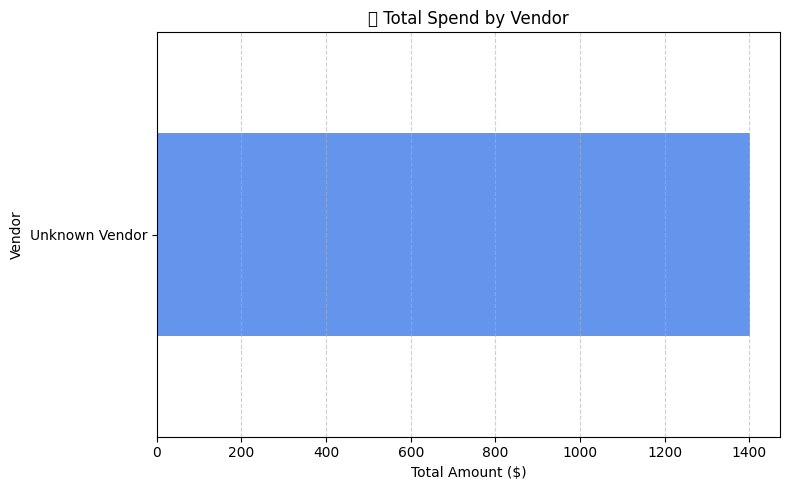

/tmp/ipython-input-562641532.py:41: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


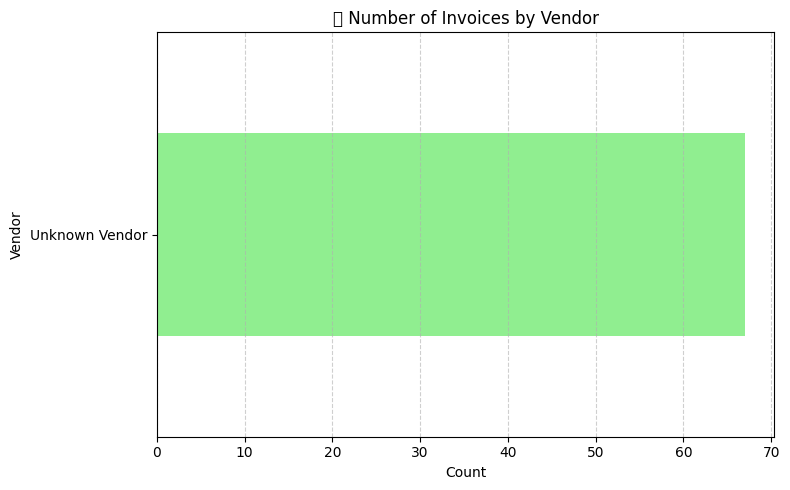

/tmp/ipython-input-562641532.py:51: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


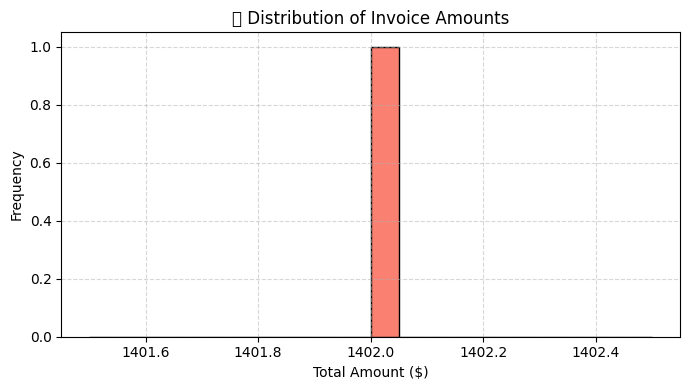

/tmp/ipython-input-562641532.py:62: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


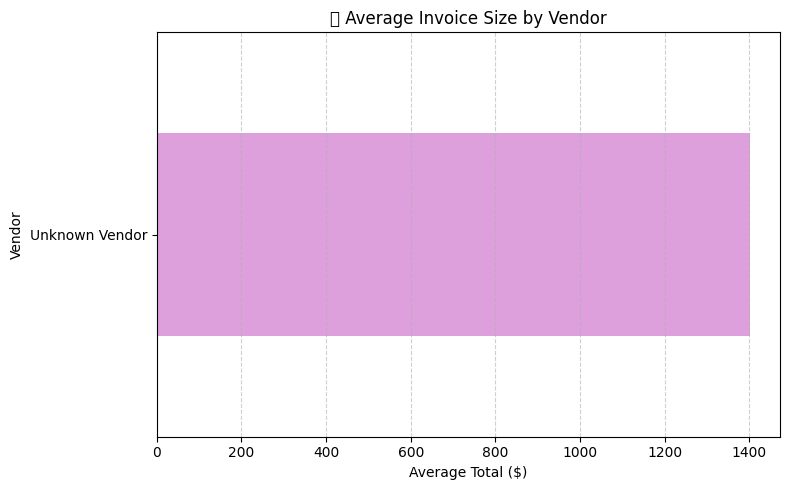

/tmp/ipython-input-562641532.py:73: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129383 (\N{PIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


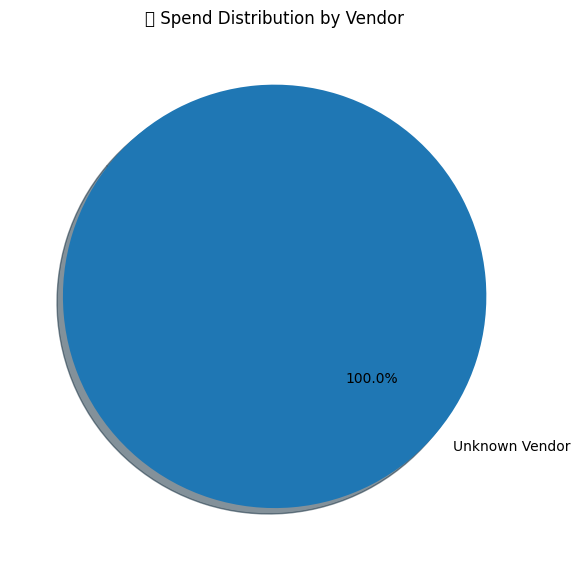

/tmp/ipython-input-562641532.py:122: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x500 with 0 Axes>

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


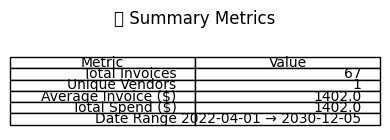

In [83]:
# ===============================
# 📊 Visualization & Performance Summary
# ===============================

if data.empty:
    print("⚠️ No data available to generate plots.")
else:
    # --- Basic column validation ---
    for col in ["vendor_name", "total_amount", "invoice_date"]:
        if col not in data.columns:
            data[col] = None

    # --- Clean and normalize ---
    data["total_amount"] = pd.to_numeric(data["total_amount"], errors="coerce").fillna(0)
    data["vendor_name"] = data["vendor_name"].fillna("Unknown Vendor").astype(str).str.strip()
    data["invoice_date"] = pd.to_datetime(data["invoice_date"], errors="coerce")

    # --- Filter valid entries ---
    valid_data = data[data["total_amount"] > 0].copy()

    # 1️⃣ Total Spend by Vendor
    plt.figure(figsize=(8, 5))
    vendor_spend = valid_data.groupby("vendor_name")["total_amount"].sum().sort_values()
    if not vendor_spend.empty:
        vendor_spend.plot(kind="barh", color="cornflowerblue")
        plt.title("💰 Total Spend by Vendor")
        plt.xlabel("Total Amount ($)")
        plt.ylabel("Vendor")
        plt.grid(axis="x", linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    # 2️⃣ Invoice Count by Vendor
    plt.figure(figsize=(8, 5))
    vendor_count = data["vendor_name"].value_counts()
    vendor_count.plot(kind="barh", color="lightgreen")
    plt.title("📦 Number of Invoices by Vendor")
    plt.xlabel("Count")
    plt.ylabel("Vendor")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # 3️⃣ Distribution of Invoice Totals
    plt.figure(figsize=(7, 4))
    plt.hist(valid_data["total_amount"], bins=20, color="salmon", edgecolor="black")
    plt.title("📈 Distribution of Invoice Amounts")
    plt.xlabel("Total Amount ($)")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 4️⃣ Average Invoice Size per Vendor
    plt.figure(figsize=(8, 5))
    avg_invoice = valid_data.groupby("vendor_name")["total_amount"].mean().sort_values()
    avg_invoice.plot(kind="barh", color="plum")
    plt.title("📊 Average Invoice Size by Vendor")
    plt.xlabel("Average Total ($)")
    plt.ylabel("Vendor")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # 5️⃣ Pie Chart — Spend Distribution
    if not vendor_spend.empty:
        plt.figure(figsize=(6, 6))
        vendor_spend.plot(
            kind="pie", autopct='%1.1f%%', startangle=140, shadow=True, cmap="tab20"
        )
        plt.title("🥧 Spend Distribution by Vendor")
        plt.ylabel("")
        plt.tight_layout()
        plt.show()

    # 6️⃣ Time Series — Spend Over Time
    if "invoice_date" in data.columns and not data["invoice_date"].isna().all():
        plt.figure(figsize=(10, 5))
        time_series = valid_data.groupby("invoice_date")["total_amount"].sum().dropna()
        if not time_series.empty:
            time_series.plot(marker="o", color="teal")
            plt.title("📅 Total Spend Over Time")
            plt.xlabel("Invoice Date")
            plt.ylabel("Total Amount ($)")
            plt.grid(True, linestyle="--", alpha=0.5)
            plt.tight_layout()
            plt.show()

    # 7️⃣ Correlation Heatmap
    numeric_data = valid_data.select_dtypes(include=['float', 'int'])
    if not numeric_data.empty and len(numeric_data.columns) > 1:
        plt.figure(figsize=(5, 4))
        corr = numeric_data.corr()
        plt.imshow(corr, cmap='coolwarm', interpolation='none')
        plt.colorbar(label="Correlation")
        plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
        plt.yticks(range(len(corr.columns)), corr.columns)
        plt.title("🔍 Correlation Heatmap")
        plt.tight_layout()
        plt.show()

    # 8️⃣ Summary Metrics
    metrics = {
        "Total Invoices": len(data),
        "Unique Vendors": data["vendor_name"].nunique(),
        "Average Invoice ($)": round(valid_data["total_amount"].mean(), 2),
        "Total Spend ($)": round(valid_data["total_amount"].sum(), 2),
        "Date Range": f"{data['invoice_date'].min().date()} → {data['invoice_date'].max().date()}" if not data['invoice_date'].isna().all() else "N/A"
    }

    fig, ax = plt.subplots(figsize=(4, 1.5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(
        cellText=[[k, v] for k, v in metrics.items()],
        colLabels=["Metric", "Value"],
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    plt.title("📊 Summary Metrics", pad=20)
    plt.tight_layout()
    plt.show()


📊 --- Pipeline Summary ---
🧾 Total invoices: 67
🏢 Unique vendors: 1
💰 Total spend: $1,402.0
📈 Average invoice amount: $20.93

⚙️ Data Quality:
❌ Missing Vendor Names: 67
❌ Missing Totals: 66
❌ Missing Dates: 61


/tmp/ipython-input-2488389062.py:41: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127970 (\N{OFFICE BUILDING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


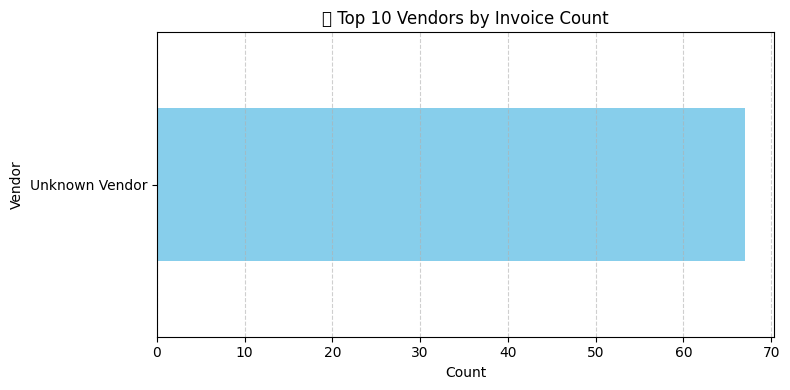

/tmp/ipython-input-2488389062.py:54: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


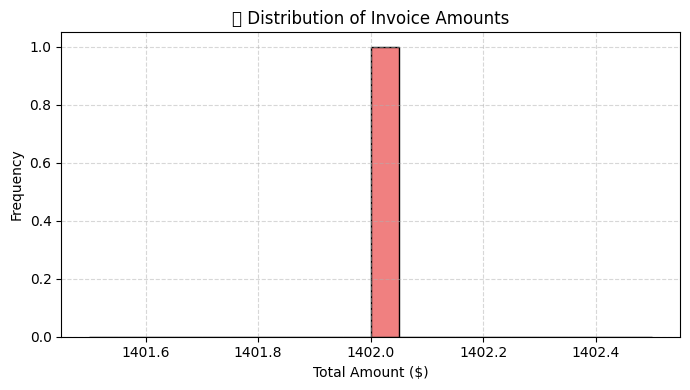

/tmp/ipython-input-2488389062.py:67: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


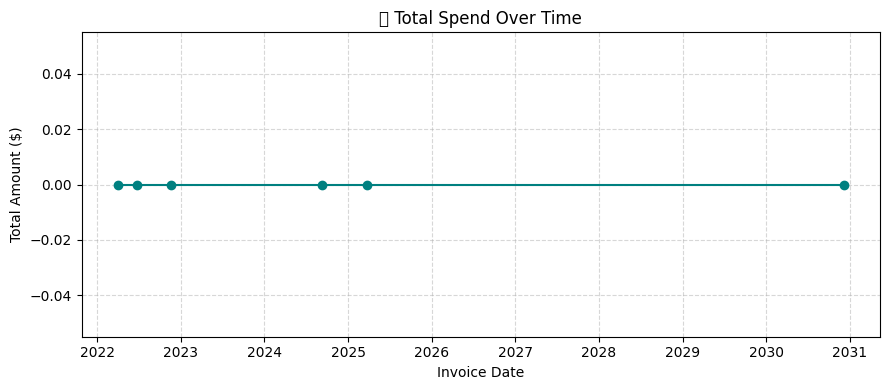

/tmp/ipython-input-2488389062.py:89: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


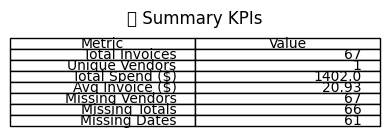

In [84]:
# === Summary Metrics + Visual Overview ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Ensure clean numeric & categorical data ---
data["total_amount"] = pd.to_numeric(data.get("total_amount", 0), errors="coerce").fillna(0)
data["vendor_name"] = data.get("vendor_name", "Unknown Vendor").fillna("Unknown Vendor").astype(str).str.strip()
data["invoice_date"] = pd.to_datetime(data.get("invoice_date", None), errors="coerce")

# --- KPIs ---
total_invoices = len(data)
unique_vendors = data["vendor_name"].nunique()
total_spend = round(data["total_amount"].sum(), 2)
avg_invoice = round(data["total_amount"].mean(), 2)

print("📊 --- Pipeline Summary ---")
print(f"🧾 Total invoices: {total_invoices}")
print(f"🏢 Unique vendors: {unique_vendors}")
print(f"💰 Total spend: ${total_spend:,}")
print(f"📈 Average invoice amount: ${avg_invoice:,}")

# --- Data Quality ---
missing_vendor = data["vendor_name"].eq("Unknown Vendor").sum()
missing_total = (data["total_amount"] == 0).sum()
missing_date = data["invoice_date"].isna().sum()

print("\n⚙️ Data Quality:")
print(f"❌ Missing Vendor Names: {missing_vendor}")
print(f"❌ Missing Totals: {missing_total}")
print(f"❌ Missing Dates: {missing_date}")

# --- Visual 1: Top 10 Vendors by Invoice Count ---
if not data.empty:
    plt.figure(figsize=(8,4))
    data["vendor_name"].value_counts().head(10).plot(kind="barh", color="skyblue")
    plt.title("🏢 Top 10 Vendors by Invoice Count")
    plt.xlabel("Count")
    plt.ylabel("Vendor")
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- Visual 2: Distribution of Invoice Amounts ---
if not data.empty:
    plt.figure(figsize=(7,4))
    valid_amounts = data[data["total_amount"] > 0]["total_amount"]
    if not valid_amounts.empty:
        plt.hist(valid_amounts, bins=20, color="lightcoral", edgecolor="black")
        plt.title("💵 Distribution of Invoice Amounts")
        plt.xlabel("Total Amount ($)")
        plt.ylabel("Frequency")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

# --- Visual 3: Time Trend of Spend (if available) ---
if "invoice_date" in data.columns and not data["invoice_date"].isna().all():
    plt.figure(figsize=(9,4))
    trend = data.groupby("invoice_date")["total_amount"].sum().dropna()
    if not trend.empty:
        plt.plot(trend.index, trend.values, marker="o", color="teal")
        plt.title("📅 Total Spend Over Time")
        plt.xlabel("Invoice Date")
        plt.ylabel("Total Amount ($)")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.tight_layout()
        plt.show()

# --- Summary Table ---
metrics = {
    "Total Invoices": total_invoices,
    "Unique Vendors": unique_vendors,
    "Total Spend ($)": total_spend,
    "Avg Invoice ($)": avg_invoice,
    "Missing Vendors": missing_vendor,
    "Missing Totals": missing_total,
    "Missing Dates": missing_date
}

fig, ax = plt.subplots(figsize=(4,1.5))
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=[[k, v] for k, v in metrics.items()],
                 colLabels=["Metric", "Value"], loc="center")
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.title("📈 Summary KPIs", pad=15)
plt.tight_layout()
plt.show()


In [85]:
print("✅ Pipeline Summary")

# --- Safety & cleanup ---
if "total_amount" not in data.columns:
    data["total_amount"] = 0
if "vendor_name" not in data.columns:
    data["vendor_name"] = "Unknown Vendor"

# Convert numeric safely
data["total_amount"] = pd.to_numeric(data["total_amount"], errors="coerce").fillna(0)
data["vendor_name"] = data["vendor_name"].fillna("Unknown Vendor")

# --- Summary metrics ---
summary = {
    "🧾 Total invoices": len(data),
    "🏢 Vendors found": data["vendor_name"].nunique(),
    "💰 Total spend ($)": round(data["total_amount"].sum(), 2),
    "📈 Average invoice total ($)": round(data["total_amount"].mean(), 2),
    "💵 Max invoice total ($)": round(data["total_amount"].max(), 2)
}

# --- Print nicely formatted metrics ---
for k, v in summary.items():
    print(f"{k}: {v:,}")

# --- Extra: Basic data completeness info ---
missing_vendor = data["vendor_name"].eq("Unknown Vendor").sum()
missing_total = (data["total_amount"] == 0).sum()

print("\n⚙️ Data Quality Check:")
print(f"❌ Missing vendor names: {missing_vendor}")
print(f"❌ Missing or zero totals: {missing_total}")



✅ Pipeline Summary
🧾 Total invoices: 67
🏢 Vendors found: 1
💰 Total spend ($): 1,402.0
📈 Average invoice total ($): 20.93
💵 Max invoice total ($): 1,402.0

⚙️ Data Quality Check:
❌ Missing vendor names: 67
❌ Missing or zero totals: 66


In [86]:
import pandas as pd
import sqlite3

# Load predictions from SQLite
conn = sqlite3.connect("invoices.db")
preds = pd.read_sql("SELECT * FROM invoices", conn)
conn.close()

# Define expected columns
expected_cols = ["file_name", "invoice_number", "invoice_date", "vendor_name", "total_amount"]

# Ensure all expected columns exist
for col in expected_cols:
    if col not in preds.columns:
        preds[col] = None

# Create a labeled sample (if dataset < 10 rows, take all)
sample = preds[expected_cols].head(10)

# Save to Drive
output_path = "/content/drive/MyDrive/ground_truth.csv"
sample.to_csv(output_path, index=False)

print(f"📝 Created '{output_path}' — open in Google Drive and fill true values for evaluation.")



📝 Created '/content/drive/MyDrive/ground_truth.csv' — open in Google Drive and fill true values for evaluation.


In [87]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
import pandas as pd

print("📥 Loading ground truth and predictions for evaluation...")

# Paths
gt_path = "/content/drive/MyDrive/ground_truth.csv"  # ✅ labeled ground truth
pred_path = "structured_invoices.csv"                # ✅ model predictions

# Load data
ground_truth = pd.read_csv(gt_path)
preds = pd.read_csv(pred_path)

# Ensure expected columns
required_cols = ["file_name", "invoice_number", "invoice_date", "vendor_name", "total_amount"]
for col in required_cols:
    if col not in ground_truth.columns:
        ground_truth[col] = None
    if col not in preds.columns:
        preds[col] = None

# Merge on file_name
merged = pd.merge(ground_truth, preds, on="file_name", suffixes=("_true", "_pred"))
print("✅ Merged data shape:", merged.shape)
display(merged.head())

# Convert numeric
merged["total_amount_true"] = pd.to_numeric(merged["total_amount_true"], errors="coerce").fillna(0)
merged["total_amount_pred"] = pd.to_numeric(merged["total_amount_pred"], errors="coerce").fillna(0)

# ----------------------------
# 📊 Field-Level Accuracy
# ----------------------------
def field_accuracy(col_true, col_pred):
    return np.mean(col_true == col_pred)

print("\n📊 Field-Level Accuracy:")
for field in ["invoice_number", "invoice_date", "vendor_name"]:
    acc = field_accuracy(merged[f"{field}_true"], merged[f"{field}_pred"])
    print(f"{field:15s}: {acc:.2%}")

merged["amount_close"] = np.isclose(
    merged["total_amount_true"], merged["total_amount_pred"], atol=5.0
)
print(f"total_amount (±$5 tolerance): {merged['amount_close'].mean():.2%}")

# ----------------------------
# 🧮 Per-Field F1 / Precision / Recall
# ----------------------------
fields = ["invoice_number", "invoice_date", "vendor_name", "total_amount"]

print("\n🔍 Detailed Field-Level Metrics:")
for field in fields:
    y_true = merged[f"{field}_true"].fillna("").astype(str)
    y_pred = merged[f"{field}_pred"].fillna("").astype(str)

    # Binary match indicator
    y_true_binary = np.ones(len(y_true))
    y_pred_binary = (y_true == y_pred).astype(int)

    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    accuracy = accuracy_score(y_true_binary, y_pred_binary)

    print(f"\n📄 {field.upper()}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-score:  {f1:.3f}")
    print(f"  Accuracy:  {accuracy:.3f}")


📥 Loading ground truth and predictions for evaluation...
✅ Merged data shape: (670, 9)


,file_name,invoice_number_true,invoice_date_true,vendor_name_true,total_amount_true,invoice_number_pred,invoice_date_pred,vendor_name_pred,total_amount_pred
0,invoice.xlsx,#612345,NaN,Unknown Vendor,0.0,#612345,NaN,Unknown Vendor,0.0
1,invoice.xlsx,#612345,NaN,Unknown Vendor,0.0,#01234,5 December 2030,Unknown Vendor,0.0
2,invoice.xlsx,#612345,NaN,Unknown Vendor,0.0,INV-01234,"April 11, 2023",Unknown Vendor,0.0
3,invoice.xlsx,#612345,NaN,Unknown Vendor,0.0,12345,NaN,Unknown Vendor,0.0
4,invoice.xlsx,#612345,NaN,Unknown Vendor,0.0,#123456,01 April 2022,Unknown Vendor,0.0



📊 Field-Level Accuracy:
invoice_number : 1.49%
invoice_date   : 1.04%
vendor_name    : 100.00%
total_amount (±$5 tolerance): 98.51%

🔍 Detailed Field-Level Metrics:

📄 INVOICE_NUMBER
  Precision: 1.000
  Recall:    0.051
  F1-score:  0.097
  Accuracy:  0.051

📄 INVOICE_DATE
  Precision: 1.000
  Recall:    0.167
  F1-score:  0.286
  Accuracy:  0.167

📄 VENDOR_NAME
  Precision: 1.000
  Recall:    1.000
  F1-score:  1.000
  Accuracy:  1.000

📄 TOTAL_AMOUNT
  Precision: 1.000
  Recall:    0.985
  F1-score:  0.992
  Accuracy:  0.985


📊 Detailed Per-Field Evaluation Metrics:


,Field,Precision,Recall,F1,Accuracy
0,invoice_number,1.0,0.050746,0.096591,0.050746
1,invoice_date,1.0,0.167164,0.286445,0.167164
2,vendor_name,1.0,1.000000,1.000000,1.000000
3,total_amount,1.0,0.985075,0.992481,0.985075


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


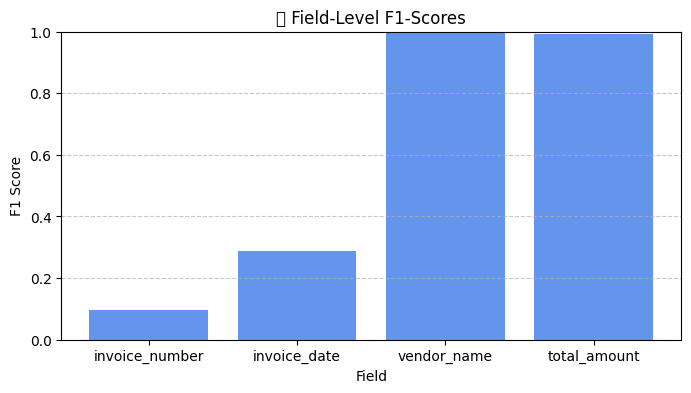

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


🏆 Overall Weighted F1 Score: 0.594


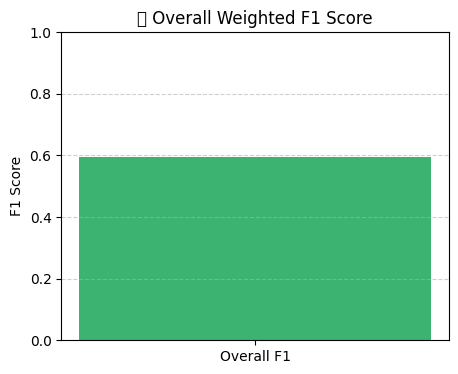

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Fields to evaluate
fields = ["invoice_number", "invoice_date", "vendor_name", "total_amount"]

field_metrics = []
for f in fields:
    y_true = merged[f"{f}_true"].fillna("").astype(str)
    y_pred = merged[f"{f}_pred"].fillna("").astype(str)

    # Binary match indicator
    y_true_binary = np.ones(len(y_true))
    y_pred_binary = (y_true == y_pred).astype(int)

    precision = precision_score(y_true_binary, y_pred_binary, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true_binary, y_pred_binary, zero_division=0)
    accuracy = accuracy_score(y_true_binary, y_pred_binary)

    field_metrics.append([f, precision, recall, f1, accuracy])

# --- Build summary DataFrame ---
metrics_df = pd.DataFrame(field_metrics, columns=["Field", "Precision", "Recall", "F1", "Accuracy"])
print("📊 Detailed Per-Field Evaluation Metrics:")
display(metrics_df)

# --- Plot Field-wise F1 Scores ---
plt.figure(figsize=(8,4))
plt.bar(metrics_df["Field"], metrics_df["F1"], color="cornflowerblue")
plt.title("📈 Field-Level F1-Scores")
plt.xlabel("Field")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# --- Weighted Average (simple mean) ---
overall_f1 = metrics_df["F1"].mean()
print(f"🏆 Overall Weighted F1 Score: {overall_f1:.3f}")

plt.figure(figsize=(5,4))
plt.bar(["Overall F1"], [overall_f1], color="mediumseagreen")
plt.title("🏆 Overall Weighted F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


/tmp/ipython-input-3351586510.py:30: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


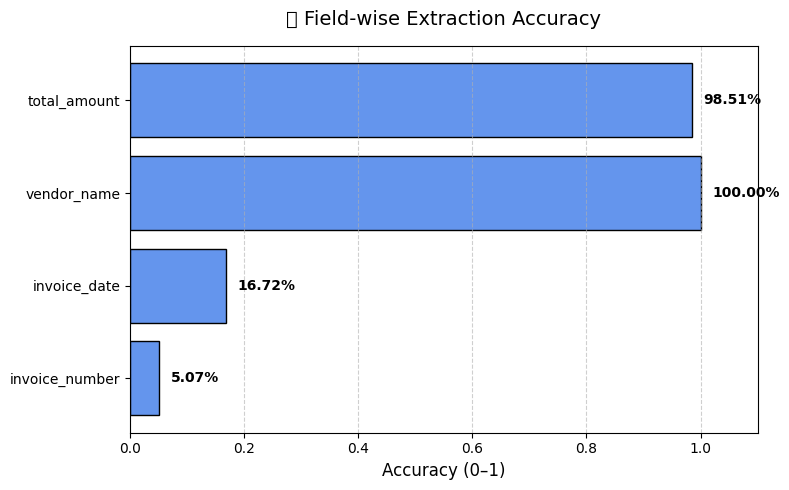

In [89]:
import matplotlib.pyplot as plt
import numpy as np

# --- Define fields and compute accuracies ---
fields = ["invoice_number", "invoice_date", "vendor_name", "total_amount"]
accuracies = []

for f in fields:
    if f == "total_amount":
        acc = merged["amount_close"].mean() if "amount_close" in merged.columns else 0
    else:
        y_true = merged[f"{f}_true"].fillna("").astype(str)
        y_pred = merged[f"{f}_pred"].fillna("").astype(str)
        acc = np.mean(y_true == y_pred)
    accuracies.append(acc)

# --- Plot ---
plt.figure(figsize=(8, 5))
bars = plt.barh(fields, accuracies, color="cornflowerblue", edgecolor="black")

# Add accuracy labels next to bars
for bar, acc in zip(bars, accuracies):
    plt.text(acc + 0.02, bar.get_y() + bar.get_height()/2,
             f"{acc:.2%}", va='center', fontsize=10, fontweight='bold')

plt.title("📊 Field-wise Extraction Accuracy", fontsize=14, pad=15)
plt.xlabel("Accuracy (0–1)", fontsize=12)
plt.xlim(0, 1.1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
